In [1]:
import time_series
import brownian
from importlib import reload
reload(time_series)
reload(brownian)

from time_series import Collection, TimeSeries, find_ders, find_files
from brownian import (make_sim_params, sim, abc_guess, get_krhoA,
     kB, gaussian_func, psd_func, msd_func, pac_func, vac_func, logbin_func)
import matplotlib.pyplot as plt
import numpy as np
from nptdms import TdmsFile
import os
from copy import copy
from time import time
%matplotlib inline


# TimeSeries class

In [2]:
# Make some fake time series data
size = 2**20  # number of points
r = 25e6  # sample rate
x = np.random.randn(size) # data axis
timeseries = TimeSeries(x, r=r)

## Raw data

In [3]:
# Call the instance to return the (time, coordinate) data
timeseries()

(array([0.000000e+00, 4.000000e-08, 8.000000e-08, ..., 4.194292e-02,
        4.194296e-02, 4.194300e-02]),
 array([-0.40621783,  1.64194766,  0.04066049, ..., -0.81398392,
         0.33773855, -0.56247008]))

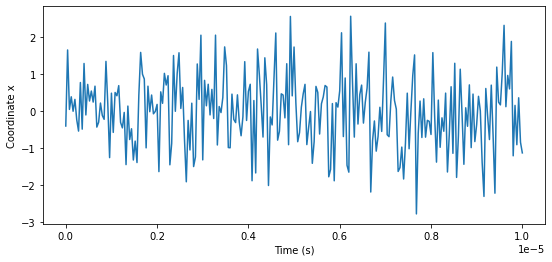

In [4]:
# Plot method for the raw coordinate data
timeseries.plot(tmin=0, tmax=1e-5);

## Bin averaging raw data

In [5]:
# Average `Npts` consecutive points (lowpass filter)
timeseries.restore() # More on this in a moment
timeseries.bin_average(Npts=10) # Return the filtered data

(array([1.800000e-07, 5.800000e-07, 9.800000e-07, ..., 4.194178e-02,
        4.194218e-02, 4.194258e-02]),
 array([ 0.14523747,  0.30650072,  0.14097698, ..., -0.28361088,
        -0.33699929,  0.39249505]))

Automatically updated
     size: 104857, sampling rate: 2.5 MHz


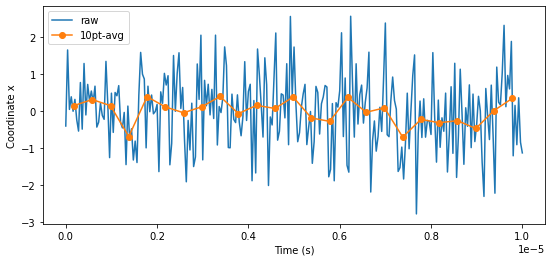

In [6]:
# update the timeseires with the smoothed data by setting `inplace=True`
fig, ax = timeseries.plot(tmin=0, tmax=1e-5, label='raw');
Npts = 10
timeseries.restore()
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.plot(ax=ax, tmin=0, tmax=1e-5, marker="o", label=f"{Npts}pt-avg")
ax.legend()
print("Automatically updated")
print(f"     size: {timeseries.size}, sampling rate: {timeseries.r/1e6} MHz")

size: 1048576, sampling rate: 25.0 MHz


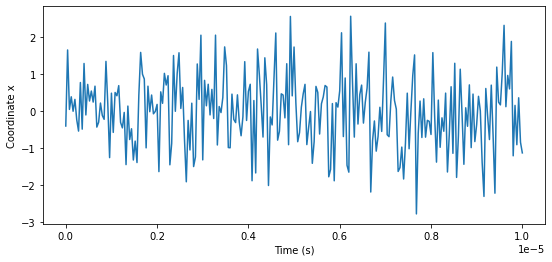

In [7]:
# Restore the raw data
timeseries.restore()
timeseries.plot(tmin=0, tmax=1e-5, label='raw')
print(f"size: {timeseries.size}, sampling rate: {timeseries.r/1e6} MHz")

## Histograms (HIST)

In [8]:
# Comute and return the coordinate histogram 
# Data is automatically  stored in the `bins` and `hist` attributes
timeseries.HIST(Nbins=25)

(array([-4.93365226, -4.51490171, -4.09615116, -3.67740061, -3.25865006,
        -2.83989951, -2.42114896, -2.00239841, -1.58364786, -1.16489731,
        -0.74614676, -0.32739621,  0.09135434,  0.51010489,  0.92885544,
         1.34760599,  1.76635654,  2.18510709,  2.60385764,  3.02260819,
         3.44135874,  3.86010929,  4.27885984,  4.69761039]),
 array([6.83229115e-06, 2.50517342e-05, 1.02484367e-04, 5.07866975e-04,
        2.07473908e-03, 7.54740429e-03, 2.17813442e-02, 5.51821382e-02,
        1.15358681e-01, 2.03668322e-01, 3.01206110e-01, 3.75650754e-01,
        3.94735621e-01, 3.48629043e-01, 2.58900563e-01, 1.61141864e-01,
        8.42876985e-02, 3.77438537e-02, 1.37237955e-02, 4.34761460e-03,
        1.11138603e-03, 2.57349633e-04, 5.23808988e-05, 1.36645823e-05]),
 1)

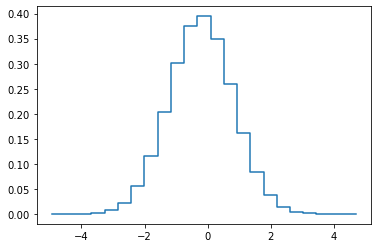

In [9]:
plt.step(timeseries.bins, timeseries.hist);

# Or calculate, and plot all at once by `*` unpacking
#plt.step(*timeseries.HIST(Nbins=25))

Average over 4 histograms, each from at most 0.01 seconds of data


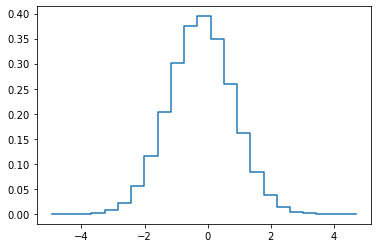

In [10]:
# Set 'taumax' to partition the data in sets of length taumax seconds
# and averag the histogram over the partitions
taumax=10e-3
timeseries.HIST(Nbins=25, taumax=taumax)
print(f"Average over {timeseries.Navg_hist} histograms, each from at most {taumax} seconds of data")
plt.step(timeseries.bins, timeseries.hist);

## Power spctral density (PSD)

Average over 4 spectra, each from at most 0.01 seconds of data


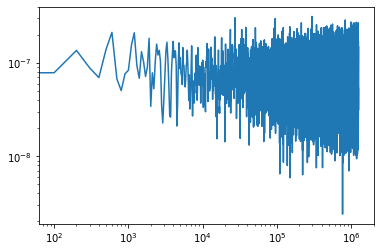

In [11]:
# restore raw data
timeseries.restore()
# set up analysis parameters
Npts = 10
taumax = 10e-3
# analysis 
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.PSD(taumax=taumax)
#reporting
print(f"Average over {timeseries.Navg_psd} spectra, each from at most {taumax} seconds of data")
plt.loglog(timeseries.freq, timeseries.psd)

## Mean-squared displacement (MSD)

Average over 2 MSDs, each from at most 0.02 seconds of data


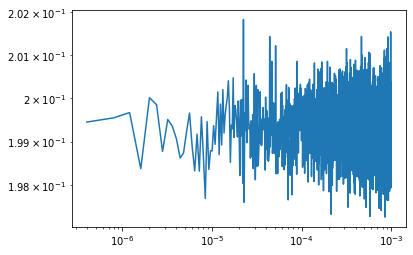

In [12]:
# As above...
timeseries.restore()
Npts = 10
taumax = 20e-3
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.MSD(taumax=taumax)
print(f"Average over {timeseries.Navg_msd} MSDs, each from at most {round(taumax,4)} seconds of data")
# Rule of thumb, good statistics up to  ~5% of record length
mask = timeseries.tmsd < taumax*0.05
plt.loglog(timeseries.tmsd[mask], timeseries.msd[mask])

## Autocorrelation function (ACF)

Average over 2 ACFs, each from at most 0.02 seconds of data


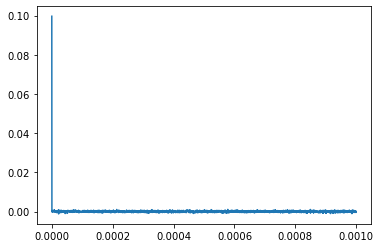

In [13]:
# As above...
timeseries.restore()
Npts = 10
taumax = 20e-3
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.ACF(taumax=taumax)
print(f"Average over {timeseries.Navg_msd} ACFs, each from at most {round(taumax,4)} seconds of data")
# Rule of thumb, good statistics up to  ~5% of record length
mask = timeseries.tacf < taumax*0.05
plt.plot(timeseries.tacf[mask], timeseries.acf[mask])

## Alan variance (AVAR) and normal variance (NVAR)

Average over 1 VARs, each from at most 0.02 seconds of data


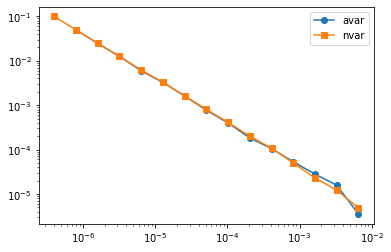

In [14]:
# As above...
timeseries.restore()
Npts = 10
timeseries.bin_average(Npts=Npts, inplace=True)
timeseries.AVAR(func=np.mean, octave=True) # Alan variance of mean, octave sampled
timeseries.NVAR(func=np.mean, octave=True) # Normal variance of mean, octave sampled
print(f"Average over {timeseries.Navg_avar} VARs, each from at most {round(taumax,4)} seconds of data")

plt.loglog(timeseries.tavar, timeseries.avar, marker="o", label="avar")
plt.loglog(timeseries.tnvar, timeseries.nvar, marker="s", label="nvar")
plt.legend()

# Find TDMS data

Given a data-drive mount mount point, the convenience functions `find_ders` and `find_files` may be used to locate desiered data files. Labview is used to save `.tdms` files. The python library `nptdms` can read these files into numpy arrays.

In [15]:
base_der = "/mnt/ext/data" # Mount point

In [16]:
date_ders = find_ders(base_der) # Experimental data is organized by date-collected
date_ders

['/mnt/ext/data/20201103',
 '/mnt/ext/data/20201111',
 '/mnt/ext/data/20201130',
 '/mnt/ext/data/20201204',
 '/mnt/ext/data/20201214',
 '/mnt/ext/data/20210113',
 '/mnt/ext/data/20210114',
 '/mnt/ext/data/20210120',
 '/mnt/ext/data/20210121',
 '/mnt/ext/data/20210202',
 '/mnt/ext/data/20210203',
 '/mnt/ext/data/20210208',
 '/mnt/ext/data/20210210',
 '/mnt/ext/data/20210408',
 '/mnt/ext/data/20210409',
 '/mnt/ext/data/20210412',
 '/mnt/ext/data/20210419']

In [17]:
date_der = date_ders[-1] # Select most recent date
run_ders = find_ders(date_der) # Further organized by a 'run name'
print(f"Available runs: {run_ders}")

Available runs: ['/mnt/ext/data/20210419/bead1']


In [18]:
files = find_files(run_ders[0])  # Each run consists of a set of trials
print(f"Available files: {files}")

Available files: ['/mnt/ext/data/20210419/bead1/trial_0.tdms', '/mnt/ext/data/20210419/bead1/trial_1.tdms']


In [19]:
file = files[0] # this is an example file.
print(f"Example file name: {file}")

Example file name: /mnt/ext/data/20210419/bead1/trial_0.tdms


In [20]:
# Read tdms files
raw_tdms = TdmsFile(file)

Available groups: [<TdmsGroup with path /'main'>]

Available channels:
   [<TdmsChannel with path /'main'/'X_0'>, <TdmsChannel with path /'main'/'Y_0'>, <TdmsChannel with path /'main'/'X_1'>, <TdmsChannel with path /'main'/'Y_1'>, <TdmsChannel with path /'main'/'X_2'>, <TdmsChannel with path /'main'/'Y_2'>, <TdmsChannel with path /'main'/'X_3'>, <TdmsChannel with path /'main'/'Y_3'>, <TdmsChannel with path /'main'/'X_4'>, <TdmsChannel with path /'main'/'Y_4'>, <TdmsChannel with path /'main'/'X_5'>, <TdmsChannel with path /'main'/'Y_5'>, <TdmsChannel with path /'main'/'X_6'>, <TdmsChannel with path /'main'/'Y_6'>, <TdmsChannel with path /'main'/'X_7'>, <TdmsChannel with path /'main'/'Y_7'>, <TdmsChannel with path /'main'/'X_8'>, <TdmsChannel with path /'main'/'Y_8'>, <TdmsChannel with path /'main'/'X_9'>, <TdmsChannel with path /'main'/'Y_9'>, <TdmsChannel with path /'main'/'X_10'>, <TdmsChannel with path /'main'/'Y_10'>, <TdmsChannel with path /'main'/'X_11'>, <TdmsChannel with path /'

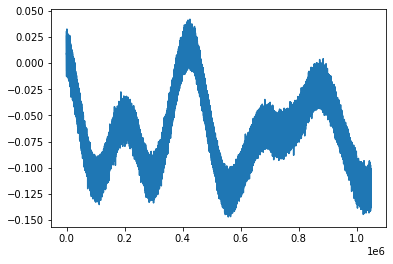

In [21]:
# Tdms files have a hierarchical organization structure:
# File.tdms --> Groups --> Channels. We use one group (`main`) with several chanels
# as well as chanel-level "properties"

# Group selection
print(f"Available groups: {raw_tdms.groups()}")
main_group = raw_tdms["main"]

# Channel selection
print(f"\nAvailable channels:\n   {main_group.channels()}")
channel = main_group["X_0"]

# Slice the channel or call a function on it to actually return the data
print(f"\n{channel}") # Return channel object
print(channel[:]) # Return channel data
plt.plot(channel);

# Tdms files can also store "properties" at the file-, group-, or channel-level.
# We store the bead size and sample rate as group-level properties

print(f"\nAvailabe properties: {main_group.properties}")
print(f"sample rate: {main_group.properties['r']}, bead radius: {main_group.properties['R']}")

# Collection class

Each TDMS file consists of `Nrecord` X-Y position records, each collected at a sampling rate `r` as well as start-of-record timestamps, forward/backward laser powers, air temperatures, heater currents, and heater voltages. The `Collection` class makes this data accessible and computable. Each instance of `Collection` has an attribute `collection` that is a list of `TimeSeries` objects. There is one `TimeSeries` object for each record of a given coordinate `coord`. 

In [22]:
X = Collection(file, coord="x")
Y = Collection(file, coord="y")

In [23]:
# Number of records per coordinate, record size, sample rate (Hz), and bead radius
# Note: Can also use Y collection for access all non-coordenate channe data
print(f"Nrecords: {X.Nrecords}, record size: {X.size}, sampling rate {X.r/1e6} MHz, bead radius {X.R/2*1e6} um")
# TODO: Labview saves bead diameter, not radius, fix on labview side

Nrecords: 44, record size: 1048576, sampling rate 25.0 MHz, bead radius 1.585 um


## Timestamps marking the start time of each record

In [24]:
X.t0s # get all time stamps (seconds)

array([0.        , 0.04201604, 0.08403248, 0.126049  , 0.16806836,
       0.21008468, 0.25210148, 0.29411696, 0.33613536, 0.37815204,
       0.42016736, 0.46218612, 0.50420288, 0.54622   , 0.58823632,
       0.63025152, 0.67226992, 0.71428596, 0.75630352, 0.79832036,
       0.84033716, 0.88235248, 0.92436884, 0.96638768, 1.00840208,
       1.05041572, 1.09243812, 1.13445492, 1.17647204, 1.21848852,
       1.26050544, 1.30252228, 1.3445392 , 1.38655584, 1.42857312,
       1.47058948, 1.51260512, 1.55462324, 1.5966384 , 1.6386568 ,
       1.68067124, 1.7226906 , 1.76470788, 1.8067216 ])

In [25]:
len(X.t0s) # There is one timestamp for each record

44

In [26]:
# Timestamp intervals
intervals = X.t0s[1:] - X.t0s[:-1]
print(f"timing accuracy: {round(np.std(intervals)*1e6 ,2)} us")

timing accuracy: 1.59 us


## Laser power, air temperature, heater current, and heater voltage

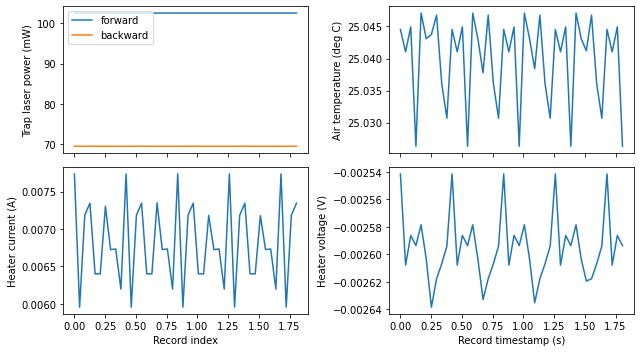

In [27]:
# Each non-coordinate channel has one value per time step.

fig, axs = plt.subplots(2,2, sharex="col", figsize=(9, 5))

axs[0,0].plot(X.t0s, X.PDFs, label="forward")
axs[0,0].plot(X.t0s, X.PDBs, label="backward")
axs[0,0].set_ylabel("Trap laser power (mW)")
axs[0,0].legend(loc="upper left")

axs[0,1].plot(X.t0s, X.Ts)
axs[0,1].set_ylabel("Air temperature (deg C)")

axs[1,0].plot(X.t0s, X.Is)
axs[1,0].set_ylabel("Heater current (A)")
axs[1,0].set_xlabel("Record index")

axs[1,1].plot(X.t0s, X.Vs)
axs[1,1].set_ylabel("Heater voltage (V)")
axs[1,1].set_xlabel("Record timestamp (s)")
plt.tight_layout()

## Collection of TimeSeries

In [28]:
len(X.collection) # a timeseries object is created for each record

44

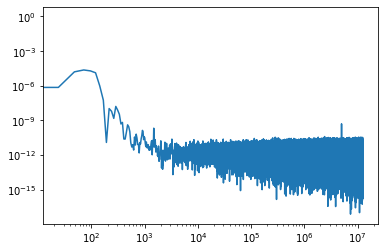

In [29]:
# Thus, all the timeseries methods are available to memebers of the collection, e.g.
x0 = X.collection[0]
plt.loglog(*x0.PSD()) # calculate and plot all at once with * unpacking

## Apply

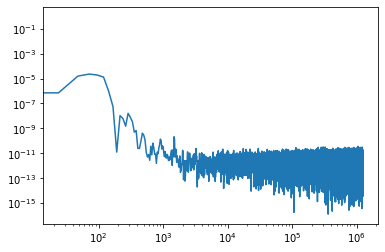

In [30]:
# Apply a timeseries restore and bin average to all members of the collection
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)
plt.loglog(*X.collection[0].PSD()) # inspect the first member

## Average

Average over 176 spectra, each from at most 0.01 seconds of data


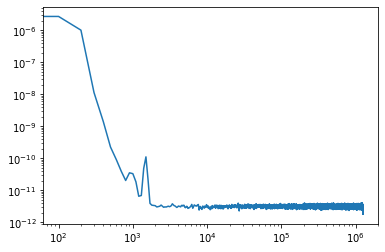

In [31]:
# Average timeseries analysis function over members of the collection
taumax = 10e-3
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)
X.average("PSD", taumax=taumax)
print(f"Average over {X.Navg_psd} spectra, each from at most {taumax} seconds of data")
plt.loglog(X.freq, X.psd)

Average over 176 spectra, each from 0.01 seconds of data


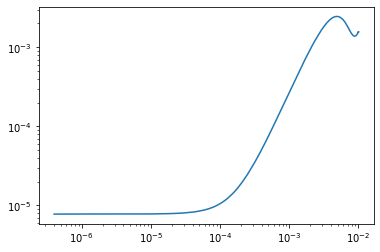

In [32]:
# Parallelized-average timeseries analysis function over members of the collection
taumax = 10e-3
n_jobs = -1 # use all avalable cores, =-2 for all-but-one 
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)
X.average("MSD", n_jobs=n_jobs, taumax=taumax)
print(f"Average over {X.Navg_msd} spectra, each from {taumax} seconds of data")
plt.loglog(X.tmsd, X.msd)

In [33]:
# Computation time scaling with number of workers
# NOTE: this calculation may take some time!
# NOE: You may want to reduce the upper bound from 33 to ~2x number of CPU cores
n_jobs_list = np.arange(1, 33)
times = []

taumax = 10e-3
X.apply("restore")
X.apply("bin_average", Npts=10, inplace=True)

for n_jobs in n_jobs_list:
    t0 = time()
    X.average("MSD", n_jobs=n_jobs, taumax=taumax)
    t1 = time()
    times.append(t1-t0)

Asymptotic speed up factor: 15.28


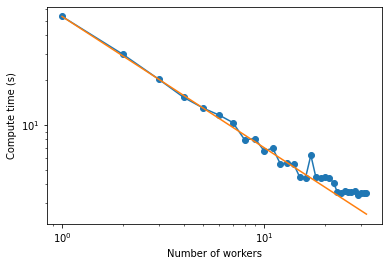

In [34]:
# NOTE: Your results may be vary.
plt.loglog(n_jobs_list, times, marker="o")
plt.loglog(n_jobs_list, times[0]/(n_jobs_list)**0.88)
plt.xlabel("Number of workers")
plt.ylabel("Compute time (s)")
print(f"Asymptotic speed up factor: {round(times[0]/times[-1], 2)}")

# Simulations

Also provided is a harmonically-bound brownian oscillator simulation and analytic results for various analysis functions.

In [35]:
# Set up simulation parameters
params = make_sim_params(
         K=np.array(
             [1e-6, 50e-6] # X, Y trap stiffness, N/m
             ),            # use two very different values for illustration
         rho=1740,         # bead density, kg/m^3
         R=3.17e-6 / 2,    # bead radius, m
         T=273.15 + 25     # air temp, K
                        )
tmax = 3.0  # maximum simulation time, s
dt = 1.0/5e6  # time resolution, s

In [36]:
# Other useful parameters are calculated from the input parameters
for k, v in params.items():
    print(f"{k} = {v}")

K = [1.e-06 5.e-05]
rho = 1740
R = 1.585e-06
eta = 1.8419824965445583e-05
T = 298.15
m = 2.9021887698034136e-14
dim = 2
gamma = 5.503207503905288e-10
Gamma = 18962.265863491917
taup = 5.2736313645158915e-05


In [37]:
# Make params dict for each dimension (for later convenience)
xparams = copy(params)
yparams = copy(params)
del xparams["K"]
del yparams["K"]
xparams["k"] = params["K"][0]
yparams["k"] = params["K"][1]

In [38]:
# Run the simulation to create positions, velocities, and times
xs, vs, ts = sim(tmax=tmax, dt=dt, **params)

In [39]:
xs.shape # (time index, coordinate index), same for vs

(15000000, 2)

In [40]:
# Load simulation data into TimeSeries objects
SX = TimeSeries(xs[:,0], r=1/dt)  # X coordinate position
SY = TimeSeries(xs[:,1], r=1/dt)  # Y coordinate position
SVX = TimeSeries(vs[:,0], r=1/dt)  # X coordinate velocity
SVY = TimeSeries(vs[:,1], r=1/dt)  # Y coordinate velocity

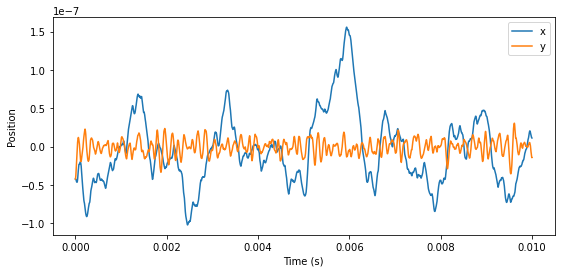

In [41]:
fig, ax = SX.plot(tmax=10e-3, label="x")
fig, ax = SY.plot(tmax=10e-3, ax=ax, label="y")
ax.set_ylabel("Position")
plt.legend()

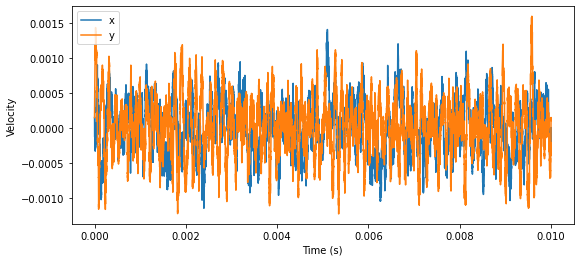

In [42]:
fig, ax = SVX.plot(tmax=10e-3, label="x")
fig, ax = SVY.plot(tmax=10e-3, ax=ax, label="y")
ax.set_ylabel("Velocity")
plt.legend()

## Histograms

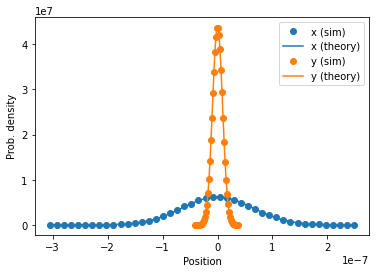

In [43]:
# Position
SX.HIST()
plt.plot(SX.bins, SX.hist, marker="o", ls="none", c="C0", label="x (sim)")
plt.plot(SX.bins, gaussian_func(SX.bins, var=kB*params["T"] / params["K"][0]), c="C0", label="x (theory)")

SY.HIST()
plt.plot(SY.bins, SY.hist, marker="o", ls="none", c="C1", label="y (sim)")
plt.plot(SY.bins, gaussian_func(SY.bins, var=kB*params["T"] / params["K"][1]), c="C1", label="y (theory)")

plt.xlabel("Position")
plt.ylabel("Prob. density")
plt.legend()

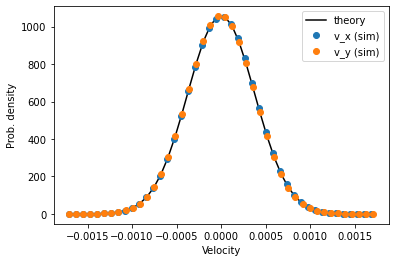

In [44]:
# Velocity
SVX.HIST()
SVY.HIST()

plt.plot(SVY.bins, gaussian_func(SVY.bins, var=kB*params["T"] / params["m"]), c="k", label="theory")


SVX.HIST()
plt.plot(SVX.bins, SVX.hist, marker="o", ls="none", c="C0", label="v_x (sim)")


SVY.HIST()
plt.plot(SVY.bins, SVY.hist, marker="o", ls="none", c="C1", label="v_y (sim)")

plt.xlabel("Velocity")
plt.ylabel("Prob. density")
plt.legend()

## Power spectral density

### Plotting

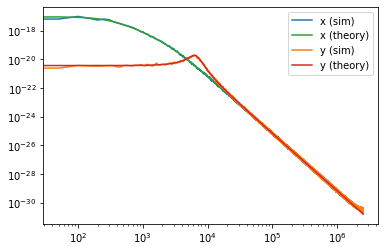

In [45]:
# Raw data plot
SX.PSD(taumax=20e-3)
SY.PSD(taumax=20e-3)
plt.loglog(SX.freq, SX.psd, c="C0", label="x (sim)")
plt.loglog(SX.freq, psd_func(SX.freq, **xparams), c="C2", label="x (theory)")
plt.loglog(SY.freq, SY.psd, c="C1", label="y (sim)")
plt.loglog(SY.freq, psd_func(SY.freq, **yparams), c="C3", label="y (theory)")
plt.legend()

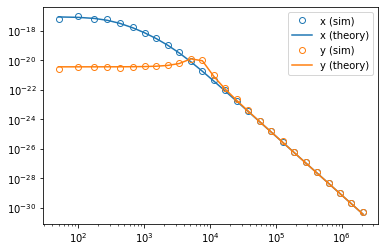

In [46]:
# Logbin average plot

Npts = 7  # points per decade

SX.PSD(taumax=20e-3)
SY.PSD(taumax=20e-3)

xfreq_plot = logbin_func(SX.freq, Npts=Npts)
yfreq_plot = logbin_func(SY.freq, Npts=Npts)
xpsd_plot = logbin_func(SX.psd, Npts=Npts)
ypsd_plot = logbin_func(SY.psd, Npts=Npts)

plt.loglog(xfreq_plot, xpsd_plot, marker="o", mec="C0", mfc="none", ls="none", label="x (sim)")
plt.loglog(xfreq_plot, psd_func(xfreq_plot, **xparams), c="C0", label="x (theory)")
plt.loglog(yfreq_plot, ypsd_plot, marker="o", mec="C1", mfc="none", ls="none", label="y (sim)")
plt.loglog(yfreq_plot, psd_func(yfreq_plot, **yparams), c="C1", label="y (theory)")
plt.legend()

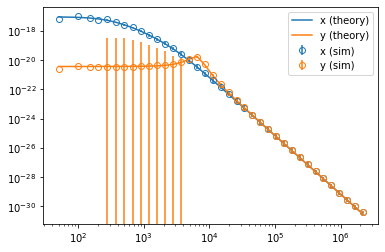

In [47]:
# Logbin average plot with errorbars sourced from log bins

Npts = 10  # points per decade

SX.PSD(taumax=20e-3)
SY.PSD(taumax=20e-3)

xfreq_plot = logbin_func(SX.freq, Npts=Npts)
yfreq_plot = logbin_func(SY.freq, Npts=Npts)
xpsd_plot = logbin_func(SX.psd, Npts=Npts)
dxpsd_plot = logbin_func(SX.psd, Npts=Npts, func=np.std)
ypsd_plot = logbin_func(SY.psd, Npts=Npts)
dypsd_plot = logbin_func(SX.psd, Npts=Npts, func=np.std)

plt.errorbar(xfreq_plot, xpsd_plot, yerr=dxpsd_plot, marker="o", mec="C0", mfc="none", ls="none", label="x (sim)")
plt.loglog(xfreq_plot, psd_func(xfreq_plot, **xparams), c="C0", label="x (theory)")
plt.errorbar(yfreq_plot, ypsd_plot, yerr=dypsd_plot, marker="o", mec="C1", mfc="none", ls="none", label="y (sim)")
plt.loglog(yfreq_plot, psd_func(yfreq_plot, **yparams), c="C1", label="y (theory)")
plt.legend()

# Note if std(bin) > mean(bin) then errorbar is drawn to x-axis on log scale

### Fitting

x coordinate
   rho (kg / m^3): 1740 (actual), 1751.94 (fitted), 0.686 (% error)
   k (fN /nm): 1.0 (actual), 0.989 (fitted), 1.1 (% error)
   A (V / m): 1.0 (actual), 1.01 (fitted), 0.719 (% error)

y coordinate
   rho (kg / m^3): 1740 (actual), 1721.94 (fitted), 1.038 (% error)
   k (fN /nm): 50.0 (actual), 49.548 (fitted), 0.904 (% error)
   A (V / m): 1.0 (actual), 0.99 (fitted), 1.072 (% error)


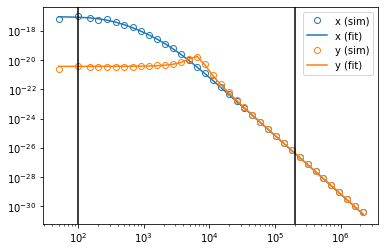

In [48]:
# masking parameters
fmin=100
fmax = 2e5

# PSD parameters
taumax = 20e-3
Npts = 10
SX.PSD(taumax=taumax)
SY.PSD(taumax=taumax)

xmask = np.logical_and(SX.freq<=fmax, SX.freq>=fmin)
xabc, xabc_cov = abc_guess(SX.freq[xmask], SX.psd[xmask], n=SX.Navg_psd)
xkrhoA = get_krhoA(*xabc, **xparams)
fitted_xparams = copy(xparams)
fitted_xparams["k"] = xkrhoA[0]
fitted_xparams["rho"] = xkrhoA[1]

ymask = np.logical_and(SY.freq<=fmax, SY.freq>=fmin)
yabc, yabc_cov = abc_guess(SY.freq[ymask], SY.psd[ymask], n=SY.Navg_psd)
ykrhoA = get_krhoA(*yabc, **yparams)
fitted_yparams = copy(yparams)
fitted_yparams["k"] = ykrhoA[0]
fitted_yparams["rho"] = ykrhoA[1]

xfreq_plot = logbin_func(SX.freq, Npts=Npts)
yfreq_plot = logbin_func(SY.freq, Npts=Npts)
xpsd_plot = logbin_func(SX.psd, Npts=Npts)
ypsd_plot = logbin_func(SY.psd, Npts=Npts)

plt.loglog(xfreq_plot, xpsd_plot, marker="o", mec="C0", mfc="none", ls="none", label="x (sim)")
plt.loglog(xfreq_plot, psd_func(xfreq_plot, **fitted_xparams), c="C0", label="x (fit)")
plt.loglog(yfreq_plot, ypsd_plot, marker="o", mec="C1", mfc="none", ls="none", label="y (sim)")
plt.loglog(yfreq_plot, psd_func(yfreq_plot, **fitted_yparams), c="C1", label="y (fit)")
plt.axvline(fmin, c="k")
plt.axvline(fmax, c="k")
plt.legend()

print("x coordinate")
for k, v in xparams.items():
    if k=="k":
        print(f"   {k} (fN /nm): {round(1e6*v,3)} (actual), {round(1e6*xkrhoA[0],3)} (fitted), {round(100*abs(v - xkrhoA[0])/v, 3)} (% error)")     
    if k=="rho":
        print(f"   {k} (kg / m^3): {round(v,3)} (actual), {round(xkrhoA[1],2)} (fitted), {round(100*abs(v - xkrhoA[1])/v, 3)} (% error)")
print(f"   A (V / m): {1.0} (actual), {round(xkrhoA[2],2)} (fitted), {round(100*abs(1 - xkrhoA[2])/1.0, 3)} (% error)")
        
print("\ny coordinate")
for k, v in yparams.items():
    if k=="k":
        print(f"   {k} (fN /nm): {round(1e6*v,3)} (actual), {round(1e6*ykrhoA[0],3)} (fitted), {round(100*abs(v - ykrhoA[0])/v, 3)} (% error)")  
    if k=="rho":
        print(f"   {k} (kg / m^3): {round(v,3)} (actual), {round(ykrhoA[1],2)} (fitted), {round(100*abs(v - ykrhoA[1])/v, 3)} (% error)")
print(f"   A (V / m): {1.0} (actual), {round(ykrhoA[2],2)} (fitted), {round(100*abs(1 - ykrhoA[2])/1.0, 3)} (% error)")
        

## Mean-squared displacement

In [ ]:
# Compute
# Note, this may take some time!
taumax = 30e-3
SX.MSD(taumax=taumax, n_jobs=-1)
SY.MSD(taumax=taumax, n_jobs=-1)

In [ ]:
#Plot

Npts = 10  # plot-points per decade

# Rule of thumb, good statistics up to  ~5% of record length
xmask = SX.tmsd < taumax*0.05
ymask = SY.tmsd < taumax*0.05

xtmsd_plot = logbin_func(SX.tmsd[xmask], Npts=Npts)
ytmsd_plot = logbin_func(SY.tmsd[ymask], Npts=Npts)
xmsd_plot = logbin_func(SX.msd[xmask], Npts=Npts)
ymsd_plot = logbin_func(SY.msd[ymask], Npts=Npts)

plt.loglog(xtmsd_plot, xmsd_plot, marker="o", ls="none", mec="C0", mfc="none", label="x (sim)")
plt.loglog(xtmsd_plot, msd_func(xtmsd_plot, **xparams), c="C0", label="x (theory)")

plt.loglog(ytmsd_plot, ymsd_plot, marker="o", ls="none", mec="C1", mfc="none", label="y (sim)")
plt.loglog(ytmsd_plot, msd_func(ytmsd_plot, **yparams), c="C1", label="y (theory)")
plt.legend()

## Position autocorrelation function

In [ ]:
taumax = 40e-3
SX.ACF(taumax=taumax, n_jobs=-1)
SY.ACF(taumax=taumax, n_jobs=-1)

In [ ]:
Npts = 10  # plot-points per decade

# Rule of thumb, good statistics up to  ~5% of record length
xmask = SX.tacf < taumax*0.05
ymask = SY.tacf < taumax*0.05

xtacf_plot = logbin_func(SX.tacf[xmask], Npts=Npts)
ytacf_plot = logbin_func(SY.tacf[ymask], Npts=Npts)
xacf_plot = logbin_func(SX.acf[xmask], Npts=Npts)
yacf_plot = logbin_func(SY.acf[ymask], Npts=Npts)

plt.plot(xtacf_plot, xacf_plot, marker="o", ls="none", mec="C0", mfc="none", label="x (sim)")
plt.plot(xtacf_plot, pac_func(xtacf_plot, **xparams), c="C0", label="x (theory)")

plt.plot(ytacf_plot, yacf_plot, marker="o", ls="none", mec="C1", mfc="none", label="y (sim)")
plt.plot(ytacf_plot, pac_func(ytacf_plot, **yparams), c="C1", label="y (theory)")

plt.xscale("log")
plt.legend()

## Velocity Autocorrelation function

In [ ]:
taumax = 40e-3
SVX.ACF(taumax=taumax, n_jobs=-1)
SVY.ACF(taumax=taumax, n_jobs=-1)

In [ ]:
Npts = 15  # plot-points per decade

# Rule of thumb, good statistics up to  ~5% of record length
xmask = SVX.tacf < taumax*0.05
ymask = SVY.tacf < taumax*0.05

xtacf_plot = logbin_func(SVX.tacf[xmask], Npts=Npts)
ytacf_plot = logbin_func(SVY.tacf[ymask], Npts=Npts)
xacf_plot = logbin_func(SVX.acf[xmask], Npts=Npts)
yacf_plot = logbin_func(SVY.acf[ymask], Npts=Npts)

plt.plot(xtacf_plot, xacf_plot, marker="o", ls="none", mec="C0", mfc="none", label="x (sim)")
plt.plot(xtacf_plot, vac_func(xtacf_plot, **xparams), c="C0", label="x (theory)")

plt.plot(ytacf_plot, yacf_plot, marker="o", ls="none", mec="C1", mfc="none", label="y (sim)")
plt.plot(ytacf_plot, vac_func(ytacf_plot, **yparams), c="C1", label="y (theory)")

plt.xscale("log")
plt.legend()